In [412]:
import warnings
warnings.filterwarnings('ignore')

In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Firstly let's look at the provided data.

In [414]:
df = pd.read_csv('../data/raw/ml-100k/u.data', sep = '\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Now let's get some information about the items and users.

In [415]:
items = pd.read_csv('../data/raw/ml-100k/u.item', sep = '|', encoding = "ISO-8859-1", header=None)
items.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


from the information provided in the description of the u.item data, we cannot get a list of genres, let's look for them in u.genre

In [416]:
genres = pd.read_csv('../data/raw/ml-100k/u.genre', sep = '|', header=None)
genres

,0,1
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


We can set this values as column names of the last 19 columns of the items dataframe, also names of the first columns are provided in the desc of u.item.

In [417]:
genre_columns = [genre[0] for genre in genres.values]
cols = ['movie id', 'movie title', 'release date', 'video release date', 'IMDB URL']
cols = cols + genre_columns

In [418]:
items.rename(columns=dict(zip(items.columns, cols)), inplace=True)
items.head()

,movie id,movie title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


let's check that all movie titles are unique

In [419]:
counts = items[['movie title']].value_counts()
counts = counts[counts > 1]
print(len(counts))
counts

18


movie title                   
Ulee's Gold (1997)                2
Desperate Measures (1998)         2
Fly Away Home (1996)              2
Hurricane Streets (1998)          2
Sliding Doors (1998)              2
Hugo Pool (1997)                  2
Chasing Amy (1997)                2
Chairman of the Board (1998)      2
Money Talks (1997)                2
Butcher Boy, The (1998)           2
Substance of Fire, The (1996)     2
Deceiver (1997)                   2
Nightwatch (1997)                 2
Designated Mourner, The (1997)    2
That Darn Cat! (1997)             2
Ice Storm, The (1997)             2
Kull the Conqueror (1997)         2
Body Snatchers (1993)             2
dtype: int64

There are 18 movies which are not unique, this means that users can rate some movie more than once. Therefore we need to deal with this situation in our main dataset: let's take an average of such ratings.

In [420]:
df = df.merge(items[['movie id', 'movie title']], left_on='item_id', right_on='movie id').drop('movie id', axis=1)

In [421]:
df = df.groupby(by=['user_id', 'movie title'], as_index=False).agg({"rating":"mean"})
df.head()

,user_id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


Now let's look at the frequency of rating number at the plot

In [422]:
freq_ratings = df['rating'].value_counts()
freq_ratings.index

Float64Index([4.0, 3.0, 5.0, 2.0, 1.0, 3.5, 4.5, 2.5, 1.5], dtype='float64')

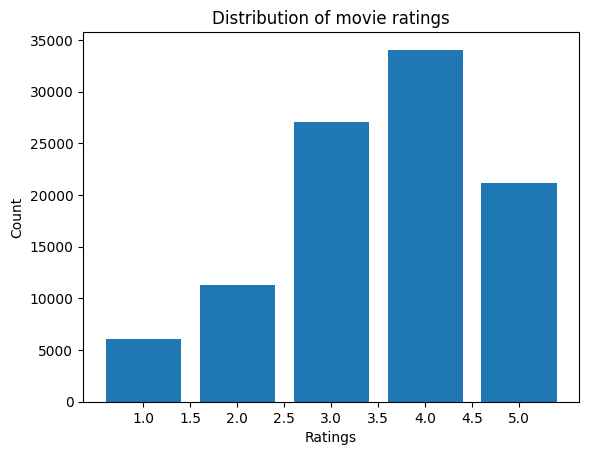

In [423]:
plt.title('Distribution of movie ratings')
plt.xticks(freq_ratings.index)
plt.bar(freq_ratings.index, freq_ratings.values)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

And also let's look how many times each movie was rated

In [424]:
freq_movies = pd.DataFrame(df.groupby('movie title').size(), columns=['count'])
freq_movies.head()

,count
movie title,
'Til There Was You (1997),9
1-900 (1994),5
101 Dalmatians (1996),109
12 Angry Men (1957),125
187 (1997),41


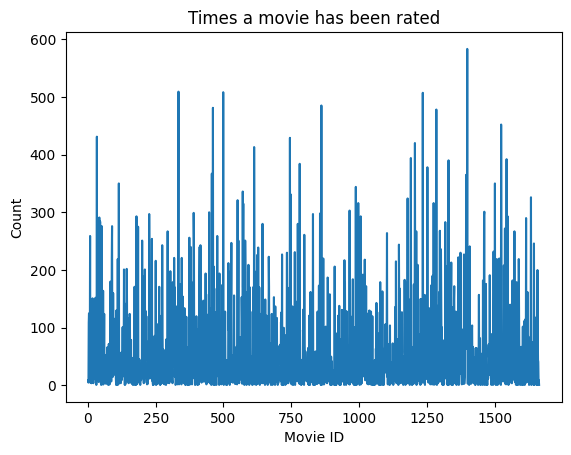

In [425]:
plt.title('Times a movie has been rated')
plt.plot(np.arange(1, len(freq_movies.index) + 1), freq_movies['count'])
plt.xlabel('Movie ID')
plt.ylabel('Count')
plt.show()

Let's get build a dataset where columns will be movie titles and index is user_id, then values are ratings of user to the corresponding movie.

In [426]:
final_df = df.pivot(
    index='user_id',
     columns='movie title',
      values='rating').fillna(0)

final_df.head()

movie title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


Now I will add demographic information about the users to the final dataset.

In [427]:
users = pd.read_csv('../data/raw/ml-100k/u.user', sep = '|', encoding = "ISO-8859-1", header=None)

users.rename(columns=dict(zip(users.columns, ['user_id', 'age', 'gender', 'occupation', 'zip_code'])), inplace=True)
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [428]:
final_df.insert(0, 'age', users['age'])
final_df.insert(1, 'gender', users['gender'])
final_df.insert(2, 'occupation', users['occupation'])
final_df.insert(3, 'zip_code', users['zip_code'])

final_df = final_df.rename_axis(None, axis="columns").reset_index()

final_df.head()

,user_id,age,gender,occupation,zip_code,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
0,1,53.0,F,other,94043,0.0,0.0,2.0,5.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
1,2,23.0,M,writer,32067,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,24.0,M,technician,43537,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,33.0,F,other,15213,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,42.0,M,executive,98101,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


Let's encode a gender and occupation to numerical data

In [429]:
final_df['gender'] = final_df['gender'].map({'M':1, 'F':2})
final_df['occupation'] = final_df['occupation'].map({v:k for k, v in enumerate(final_df['occupation'].unique())})

final_df.head()

,user_id,age,gender,occupation,zip_code,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
0,1,53.0,2.0,0,94043,0.0,0.0,2.0,5.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
1,2,23.0,1.0,1,32067,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,24.0,1.0,2,43537,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,33.0,2.0,0,15213,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,42.0,1.0,3,98101,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [434]:
final_df.to_csv('../data/interim/movie_ratings.csv', index=False)

Also let's look at the distribution of the gender, age and occupation.

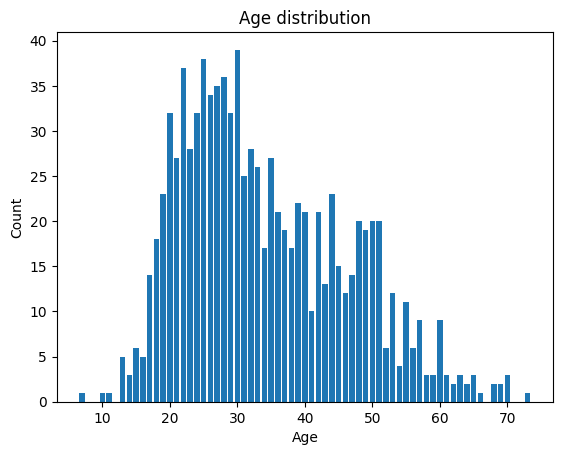

In [433]:
plt.title('Age distribution')
plt.bar(final_df.age.value_counts().sort_index().index, final_df.age.value_counts().sort_index().values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

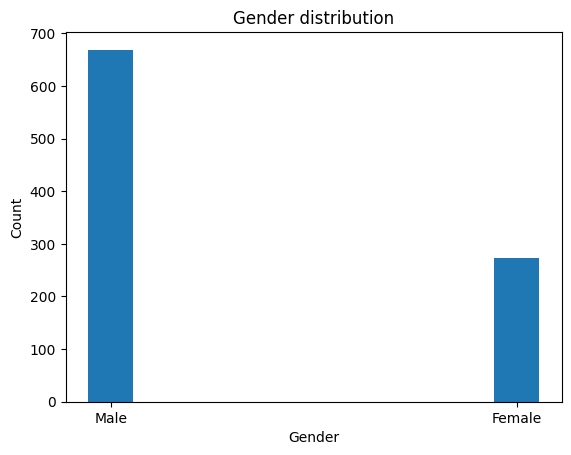

In [431]:
plt.title('Gender distribution')
plt.xticks([1.05, 1.95], ['Male', 'Female'])
plt.hist(final_df['gender'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

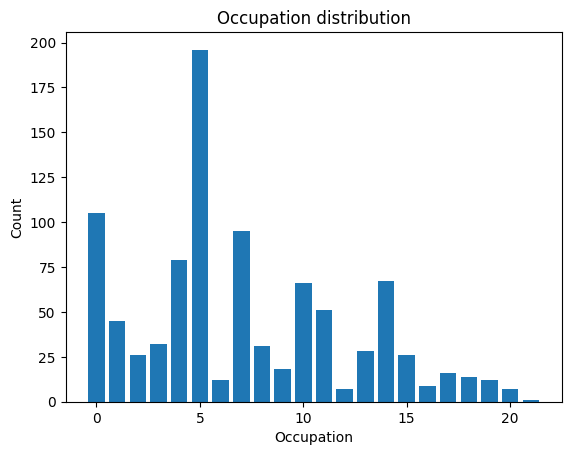

In [432]:
plt.title('Occupation distribution')
plt.bar(final_df.occupation.value_counts().sort_index().index, final_df.occupation.value_counts().sort_index().values)
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.show()